# Why I Made This Project

* Our main project is about detecting content violations in set-top box systems, where the screen will be blocked if violent content is detected. Since that involves video processing, I wanted to first experiment with image processing using MobileViT before moving to video analysis.

* In this project, if a randomly selected image is of a cat, the screen will display a black box. If it’s a dog, the image will be shown normally.

# Setup Details

* This notebook is created on **Kaggle Notebook** and runs on **GPU T4 x2**.

* **System Requirements:** A GPU-enabled environment (like Kaggle, Google Colab, or a local machine with CUDA support) is recommended for faster training and inference.

# Note on Computational Cost

Running this project on **MobileViT** is relatively efficient compared to larger vision models, but training and inference still benefit significantly from GPU acceleration. On the Kaggle Notebook with **GPU T4 x2**, the inference time is approximately **0.0166 seconds** per image. GPU memory allocated is around **296.77 MB**, with **6849.30 MB** cached. The estimated computational cost is **2.03 GFLOPs**.  

For small-scale experiments, this setup works smoothly, but for larger datasets or video processing, additional computational resources or optimization techniques may be needed.


# Step 1
# Importing Libraries and Define the Labeling Function
We first import the necessary libraries. Then we define a helper function named **assign_label** that extracts the parent folder name from each file path and assigns a label (for example, **0 for "cats" and 1 for "dogs**").

In [2]:
import os # For interacting with the operating system (e.g., file paths)  
from glob import glob # For finding file patterns in directories
import torch # Core PyTorch library for tensor computation 
from torch.utils.data import Dataset, DataLoader  # For creating and loading custom datasets  
import torchvision.transforms as transforms # For image preprocessing and augmentation
from PIL import Image # For image loading and manipulation  
import numpy as np  # For numerical operations and array handling  
from transformers import AutoImageProcessor, AutoConfig, MobileViTForImageClassification # For using pretrained MobileViT models from HuggingFace 
import random  # For generating random numbers (e.g., random seeds, shuffling)  
import matplotlib.pyplot as plt # For plotting and visualizing data



def assign_label(path):
    # Extract the folder name which is the parent folder of the file
    folder_name = os.path.basename(os.path.dirname(path)).lower()
    if folder_name in ["cats", "cat"]:
        return 0
    elif folder_name in ["dogs", "dog"]:
        return 1
    else:
        raise ValueError(f"Unexpected folder name: {folder_name} in path: {path}")

# Quick test to ensure the function works:
sample_path = "/kaggle/input/cat-and-dog/test_set/test_set/cats/sample_image.jpg"
print("Sample label:", assign_label(sample_path))


2025-05-31 16:26:01.791912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748708761.980670      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748708762.035089      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sample label: 0


# Step 2
# Create a Custom Dataset Class
This dataset loads an image, applies basic transforms (resizing, converting to tensor), then converts the image back to a NumPy array (in [0, 255] uint8 format) so that it can be processed by the Hugging Face processor. Finally, it returns the processed tensor and its label.


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        # Resize images and convert the PIL images to tensors (values between 0 and 1)
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image from the file path.
        image = Image.open(self.image_paths[idx]).convert("RGB")
        # Apply basic transforms
        image_tensor = self.transform(image)  # shape: (3, 256, 256)
        
        # Convert the tensor back to a NumPy image in the range [0, 255]
        # (transpose dimensions from C x H x W to H x W x C)
        np_image = (image_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
        pil_image = Image.fromarray(np_image).convert("RGB")
        
        # Process the image with the Hugging Face processor. We use return_tensors="pt"
        processed = processor(images=pil_image, return_tensors="pt")
        # The processor returns a batch dimension (1, C, H, W), so we take the first element.
        input_tensor = processed['pixel_values'][0]
        
        # Return the processed tensor and its corresponding label.
        label = torch.tensor(self.labels[idx], dtype=torch.int64)
        return input_tensor, label


# Step 3 
# Load the Pre-Trained Model and Reconfigure the Classification Head
We load the pre-trained MobileViT model from Hugging Face. We create a configuration that sets num_labels=2, and we use the flag ignore_mismatched_sizes=True to skip loading the classifier head (since it was originally set for a larger number of classes).

In [4]:
# Load the processor and model.
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

# Create a configuration with 2 output labels. Since Here we are working with two classes ('cats' and 'dogs')
config = AutoConfig.from_pretrained("apple/mobilevit-small", num_labels=2)

# Loading the MobileViT model for image classification with the new configuration.
model = MobileViTForImageClassification.from_pretrained(
    "apple/mobilevit-small",
    config=config,
    ignore_mismatched_sizes=True  # This overwrites the classifier head weights.
)


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

# Step 4
# Prepare File Paths, Assign Labels, and Create DataLoaders
Now we are going to use glob to collect all file paths from the training and test directories. Then we  will be assigning labels using our helper function and create dataset objects and DataLoaders.

In [5]:
# Get file paths for training images. Adjust the base directory as needed (Here I am using the path of my own directory).
train_image_paths = glob("/kaggle/input/cat-and-dog/training_set/training_set/*/*.jpg")
train_labels = [assign_label(path) for path in train_image_paths]

# Get file paths for testing images.
test_image_paths = glob("/kaggle/input/cat-and-dog/test_set/test_set/*/*.jpg")
test_labels = [assign_label(path) for path in test_image_paths]

print(f"Found {len(train_image_paths)} training images.")
print(f"Found {len(test_image_paths)} testing images.")

# Create dataset instances.
train_dataset = CustomDataset(train_image_paths, train_labels)
test_dataset = CustomDataset(test_image_paths, test_labels)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check one batch to confirm the size.
for x_batch, y_batch in train_loader:
    print("Processed batch shapes:", x_batch.shape, y_batch.shape)
    break


Found 8005 training images.
Found 2023 testing images.
Processed batch shapes: torch.Size([32, 3, 256, 256]) torch.Size([32])


# Step 5 
# Train the Model
Set up the training loop. We move the model to the GPU if available, define the optimizer and loss function, and run a training loop (here, we are running the loop for 5 times).

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Sets device to GPU if available, else CPU  
model.to(device) # Moves the model to the selected device 

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5) # Adam optimizer for adaptive learning rate  
loss_fn = torch.nn.CrossEntropyLoss()  # Cross-entropy loss for binary-class classification  

# Training loop (for demonstration, we are running 5 epochs)
model.train() # Sets the model in training mode  
for epoch in range(5):  # Increase the number of epochs as needed.
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device) # Moves input batch to device 
        y_batch = y_batch.to(device) # Moves label batch to device
        
        optimizer.zero_grad() # Clears old gradients from the last step  
        outputs = model(x_batch).logits  # MobileViT returns logits from the model output.
        loss = loss_fn(outputs, y_batch) # Computes loss between predictions and true labels
        loss.backward() # Backpropagates gradients through the model 
        optimizer.step() # Updates model parameters based on computed gradients (optimizer type depends on how we have initialized it, here we are using Adam Optimizer)
        
        print("Loss:", loss.item())
    # End of epoch
# A gradient is the derivative of the loss with respect to the model’s parameters — it tells how much and in which direction each parameter should change to reduce the loss.

Loss: 0.7103495597839355
Loss: 0.6970447897911072
Loss: 0.703238308429718
Loss: 0.6941795349121094
Loss: 0.7108209729194641
Loss: 0.6961399912834167
Loss: 0.6888737678527832
Loss: 0.6958305835723877
Loss: 0.691213071346283
Loss: 0.6958577632904053
Loss: 0.7270503044128418
Loss: 0.6998435854911804
Loss: 0.6902434825897217
Loss: 0.6849988102912903
Loss: 0.6673911809921265
Loss: 0.6622836589813232
Loss: 0.6743441224098206
Loss: 0.6789356470108032
Loss: 0.6727479100227356
Loss: 0.6568371057510376
Loss: 0.6594361066818237
Loss: 0.6603317856788635
Loss: 0.6525613069534302
Loss: 0.6613736748695374
Loss: 0.6552708148956299
Loss: 0.6459787487983704
Loss: 0.65199875831604
Loss: 0.6540356278419495
Loss: 0.6525914072990417
Loss: 0.6484948396682739
Loss: 0.6461794972419739
Loss: 0.6542316675186157
Loss: 0.6227148771286011
Loss: 0.6354801654815674
Loss: 0.6346364617347717
Loss: 0.633163571357727
Loss: 0.6338126063346863
Loss: 0.6224623322486877
Loss: 0.6107825636863708
Loss: 0.6175766587257385
Loss:

# Step 6 
# Model Evaluation
After training, compute predictions on the test set and evaluate the results. Here we also compute the confusion matrix and classification report.

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(x_batch).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y_batch.cpu().tolist())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Since there are 2 classes, print classification report only if both exist.
unique_classes = sorted(set(all_labels))
print("Unique classes in test set:", unique_classes)

if len(unique_classes) == 1:
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=unique_classes, target_names=[f"Class {unique_classes[0]}"]))
else:
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"]))


Confusion Matrix:
[[1009    2]
 [   9 1003]]
Unique classes in test set: [0, 1]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99      1011
     Class 1       1.00      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023



# Step 7
# Define a Prediction Function
This function opens an image given its file path, applies the same transforms as in your dataset, processes the image using the Hugging Face processor, feeds it into your model, and returns both the predicted label and the image (as a PIL Image) for display.

In [8]:
def predict_image(image_path, model, processor, device):
    """
    Loads an image from image_path, applies preprocessing, and returns the predicted label (as an int)
    and the original (preprocessed) PIL image.
    """
    # Open image and ensure it is RGB
    image = Image.open(image_path).convert("RGB")
    
    # Apply basic torchvision transforms (same as in our dataset)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()  # Produces float tensor in range [0,1]
    ])
    
    image_tensor = transform(image)
    
    # Convert tensor to a NumPy array in the range [0, 255] and then to a PIL image.
    np_image = (image_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    pil_image = Image.fromarray(np_image).convert("RGB")
    
    # Use the Hugging Face processor to get the proper input for the model.
    processed = processor(images=pil_image, return_tensors="pt")
    input_tensor = processed['pixel_values'][0].unsqueeze(0)  # Add a batch dimension
    
    # Move the input tensor to the device and get predictions.
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor.to(device)).logits
        prediction = torch.argmax(logits, dim=1).item()
    
    return prediction, pil_image


# Step 8
# Randomly Select an Image and Predict Its Class
Here we randomly pick one file path from the test image paths and then call the prediction function.

In [12]:
# Randomly select an image from the test set
random_image_path = random.choice(test_image_paths)
print("Randomly selected image:", random_image_path)

# Assume that my model, processor, and device were already defined.
# For example:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

predicted_label, display_image = predict_image(random_image_path, model, processor, device)

print("Predicted Label:", predicted_label)


Randomly selected image: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4481.jpg
Predicted Label: 0


# Step 9
# Display the Image with Warning if it's a cat image
Finally, we use matplotlib to display the image. If the model predicts a cat (label 0), we display a warning title; if a dog (label 1) then display normally.

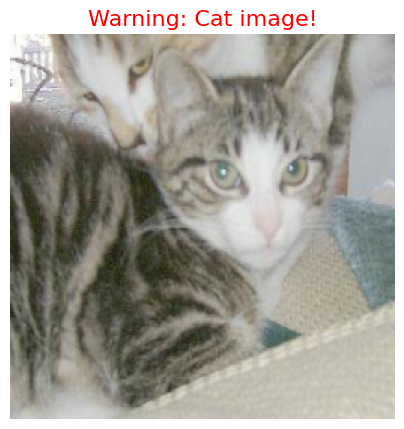

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(display_image)
plt.axis("off")

if predicted_label == 0:
    # This is a cat, display a warning.
    plt.title("Warning: Cat image!", color='red', fontsize=16)
else:
    # This is a dog, display normally.
    plt.title("Dog image", fontsize=16)
    
plt.show()


Randomly selected image: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4713.jpg
Predicted Label: 0


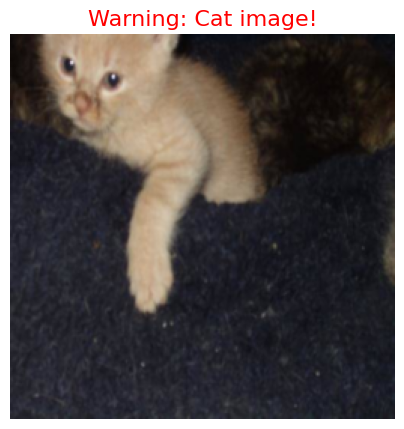

In [14]:
# Randomly select an image from the test set
random_image_path = random.choice(test_image_paths)
print("Randomly selected image:", random_image_path)

# Assume that my model, processor, and device were already defined.
# For example:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

predicted_label, display_image = predict_image(random_image_path, model, processor, device)

print("Predicted Label:", predicted_label)
plt.figure(figsize=(5,5))
plt.imshow(display_image)
plt.axis("off")

if predicted_label == 0:
    # This is a cat, display a warning.
    plt.title("Warning: Cat image!", color='red', fontsize=16)
else:
    # This is a dog, display normally.
    plt.title("Dog image", fontsize=16)
    
plt.show()


# Step 10
# Changing the Logic so that the screen will display a black box if it is a cat image.

In [16]:
random_image_path = random.choice(test_image_paths)
print("Randomly selected image:", random_image_path)
predicted_label, display_image = predict_image(random_image_path, model, processor, device)

print("Predicted Label:", predicted_label)


Randomly selected image: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4686.jpg
Predicted Label: 0


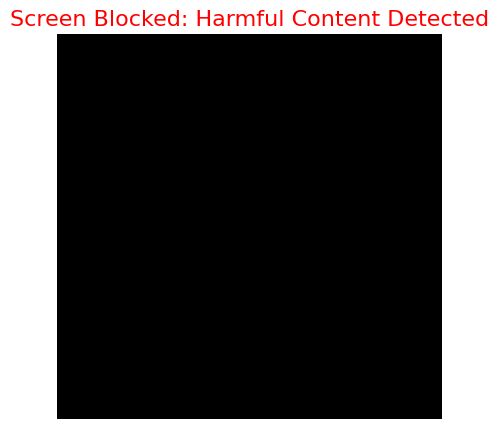

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def display_image_with_warning(image, predicted_label):
    plt.figure(figsize=(5,5))
    plt.axis("off")  # Hide axes
    
    # Use the fetched image instead of reloading
    image = np.array(image, dtype=np.uint8)  # Convert to NumPy array if needed

    if predicted_label == 0:
        # Create a blank screen with the same shape as the image
        blank_image = np.zeros_like(image)  # Matches original image size
        plt.imshow(blank_image)
        plt.title("Screen Blocked: Harmful Content Detected", color='red', fontsize=16)
    else:
        # Show the fetched image
        plt.imshow(image)
        plt.title("Safe Content", fontsize=16)
    
    plt.show()

# Call the function using the already fetched image
display_image_with_warning(display_image, predicted_label)


Randomly selected image: /kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4577.jpg
Predicted Label: 1


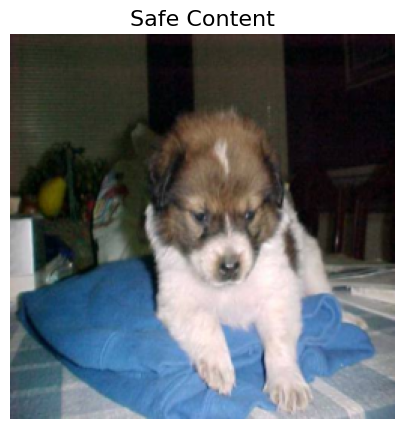

In [18]:
random_image_path = random.choice(test_image_paths)
print("Randomly selected image:", random_image_path)
predicted_label, display_image = predict_image(random_image_path, model, processor, device)

print("Predicted Label:", predicted_label)
display_image_with_warning(display_image, predicted_label)

# Step 11
# Measuring Computational Cost

In [21]:
import time


# Convert PIL Image (`display_image`) to a PyTorch tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Converts to tensor
])
image_tensor = transform(display_image).unsqueeze(0).to(device)  # Add batch dimension

# Measure Inference Time
start_time = time.time()
_ = model(image_tensor).logits  # Run inference
end_time = time.time()

print(f"\nInference Time: {end_time - start_time:.4f} seconds")

# Measure GPU/CPU Memory Usage
if torch.cuda.is_available():
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1e6:.2f} MB")
else:
    print("Running on CPU: GPU memory check not applicable.")




Inference Time: 0.0166 seconds
GPU Memory Allocated: 296.77 MB
GPU Memory Cached: 6849.30 MB


# Step 12
# Measure FLOPs for Energy Estimation

In [23]:
!pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=ab0944be46db9c640d7da77c85f88fa0edadae576e78a0ef775b1bb3bbfb40fa
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=0a3eb8640bbe62edc06ef4afb2ffa0266d3a877a1983e74ae5a897d3c0482190
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [24]:
from fvcore.nn import FlopCountAnalysis

input_tensor = torch.randn(1, 3, 256, 256).to(device)  # Example input size
flops = FlopCountAnalysis(model, input_tensor)
print(f"Estimated FLOPs: {flops.total()/1e9:.2f} GFLOPs")  # FLOPs in Giga scale


Estimated FLOPs: 2.03 GFLOPs


🔹 Lower FLOPs → Less computation required → Faster inference & lower energy usage <br>
🔹 Higher FLOPs → More complex operations → May require optimization for real-time applications

# End Of This Project